Домашнее задание.<br>
ИАД-2<br>
Жингалов Кирилл <br>
Литвинова Наталья

# Майнор "Прикладные задачи анализа данных"
## Домашнее задание 2 [10 баллов] до 23:59 22.03.2018. Предсказание цены акции по экономическим новостям


В этом домашнем задании вы попытаетесь предсказать рост цены акции компании Газпром по новостям о компании. Домашнее задание состоит из трех частей:
1. Предварительная обработка текстов и эксплоративный анализ
2. Baseline алгоритм
3. Творческая часть

Все три части можно считать независимыми – вы можете сделать одну или две из них, однако мы настоятельно советуем выполнить все три. Все инструкции по выполнению домашнего задания – ниже. 



Входные данные:
* Новости о компании "Газпром", начиная с 2010 года
* Стоимость акций компании "Газпром" на ММВБ, начиная с 2010 года
    * цена открытия (Open)
    * цена закрытия (ClosingPrice)
    * максимальная цена за день (DailyHigh)
    * минимальная цена за день (DailyLow) 
    * объем бумаг (VolumePcs)


In [26]:
import pandas as pd
import numpy as np
    
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string    
from pymorphy2 import MorphAnalyzer
import nltk
   
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

from functools import wraps
import time

In [2]:
def timeit(method):
    def timed(*args, **kw):
        ts = time.time()
        result = method(*args, **kw)
        te = time.time()
        print('Function', method.__name__, 'time:', round((te -ts)*1000,1), 'ms')
        return result
    return timed

In [3]:
@timeit
def load_data() -> (pd.DataFrame, pd.DataFrame):
    texts = pd.read_csv('data/texts.csv')
    prices = pd.read_csv('data/gazprom_prices.csv', sep=';')
    
    return texts, prices

In [4]:
# Почистим данные: приведем дату к правильному формату, отсортируем по дате разобьем строки и т.д.
@timeit
def clean_data(texts: pd.DataFrame, prices: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame):
    texts['date'] = pd.to_datetime(texts['date'])
    texts = texts.sort_values('date', ascending=True).reset_index(drop=True)
    texts['text'] = texts['text'].apply(lambda x: x.strip())
    texts = texts[texts['text'] != '']
    
    texts['text'] = texts['text'].apply(lambda x: list(x.split('\n')))
    
    prices['Date'] = pd.to_datetime(prices['Date'])
    prices = prices.sort_values('Date', ascending=True).reset_index(drop=True)
    prices[['Open', 'ClosingPrice', 'DailyHigh', 'DailyLow']] =\
    prices[['Open', 'ClosingPrice', 'DailyHigh', 'DailyLow']].apply(lambda x: x.apply(lambda y: float(str(y).replace(',', '.'))))
    
    return texts, prices

In [5]:
# Соединим датафреймы по датам которые есть в обоих
@timeit
def merge_dataframes(texts: pd.DataFrame, prices: pd.DataFrame) -> pd.DataFrame:
    all_info = texts.merge(prices, left_on='date', right_on='Date', how='inner').drop('Date', axis=1)
    all_info.sort_values(by='date', inplace=True)
    
    return all_info

In [6]:
all_info = merge_dataframes(*clean_data(*load_data()))

Function load_data time: 27.5 ms
Function clean_data time: 494.2 ms
Function merge_dataframes time: 6.4 ms


In [7]:
all_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1159 entries, 0 to 1158
Data columns (total 7 columns):
date            1159 non-null datetime64[ns]
text            1159 non-null object
Open            1145 non-null float64
ClosingPrice    1159 non-null float64
DailyHigh       1158 non-null float64
DailyLow        1157 non-null float64
VolumePcs       1159 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 72.4+ KB


## Часть 1. Вводная [3 балла]

Проведите предобработку текстов: если считаете нужным, выполните токенизацию, приведение к нижнему регистру, лемматизацию и/или стемминг. Ответьте на следующие вопросы:
* Есть ли корреляция между средней длинной текста за день и ценой закрытия?
* Есть ли корреляция между количеством упоминаний Алексея Миллера  и ценой закрытия? Учтите разные варианты написания имени.
* Упоминаний какого газопровода в статьях больше: 
    * "северный поток"
    * "турецкий поток"?
* Кого упоминают чаще:
    * Алексея Миллера
    * Владимира Путина?
* О каких санкциях пишут в статьях?

In [8]:
# Функция для токенизации строк
def tokenizer(text):
    tokens = word_tokenize(text)
    
    # Сделаем список стоп-слов
    stop_words = stopwords.words('russian')
    stop_words.extend(['г.'])
    
    # Сделаем список знаков припинания
    punctuation = list(string.punctuation)
    punctuation.extend(['«', '»', '""', '—', '``', "''", '–', '“', '”'])
    
    
    # Удалим из токенов стоп-слова и знаки припинания
    tokens = [i for i in tokens if ((i not in punctuation) and (i not in stop_words))]

    return tokens

# Функция для лемматизации слов
def lemmatizator(words_list, morph_analyzer):
    return [morph_analyzer.parse(word)[0].normal_form for word in words_list] 

# Токенизация строк в датафрейме
@timeit
def tokenize_in_df(info: pd.DataFrame) -> pd.DataFrame:
    info['text'] = [[tokenizer(sen) for sen in day] for day in info['text']]
    return info

# Проведем лемматизацию
@timeit
def lemmatize_in_df(info: pd.DataFrame) -> pd.DataFrame:
    morph = MorphAnalyzer()
    info['text'] = [[lemmatizator(sen, morph_analyzer=morph) for sen in day] for day in info['text']]
    return info

In [9]:
all_info = lemmatize_in_df(tokenize_in_df(merge_dataframes(*clean_data(*load_data()))))
all_info.head()

Function load_data time: 29.5 ms
Function clean_data time: 495.6 ms
Function merge_dataframes time: 3.8 ms
Function tokenize_in_df time: 1868.5 ms
Function lemmatize_in_df time: 18647.4 ms


,date,text,Open,ClosingPrice,DailyHigh,DailyLow,VolumePcs
0,2010-01-02,"[[газпром, исключать, 2010, выпуск, облигация,...",184.74,189.85,190.40,183.50,76298175
1,2010-01-19,"[[газпром, готовый, забирать, весь, объесть, а...",190.10,189.76,190.47,187.36,48626727
2,2010-01-28,"[[консорциум, глава, российский, оао, газпром,...",183.75,182.30,185.98,181.67,62561241
3,2010-02-07,"[[газпромбанк, открыть, кипр, дочерний, компан...",144.80,148.25,148.27,144.05,41766629
4,2010-02-09,"[[газпром, вновь, понизить, прогноз, экспорт, ...",161.79,162.80,163.57,161.53,42721026


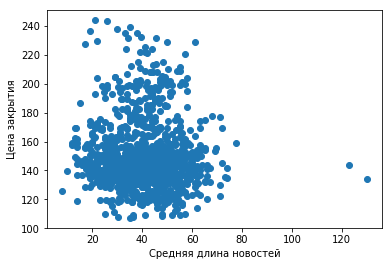

In [10]:
# Корреляции между средней длиной новостей и ценой закрытия нет
len_news = []
for lst_news in all_info['text']:
    len_mean = []
    for news in lst_news:
        len_mean.append(len(news))
    len_news.append(np.mean(len_mean))
    
plt.scatter(y=all_info['ClosingPrice'], x=len_news)
plt.xlabel('Средняя длина новостей')
plt.ylabel('Цена закрытия');

Text(0,0.5,'Количество упоминаний Алексея Миллера')

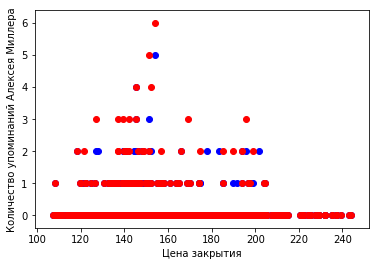

In [11]:
# Можно заметить, что корреляции между упоминаниями Алексея Миллера и ценой закрытия нет
miller_count = []
alexey_count = []
for lst_news in all_info['text']:
    miller_one_text = 0
    alexey_one_text = 0
    for news in lst_news:
        miller_one_text += news.count('миллер') 
        alexey_one_text += news.count('алексей')
    miller_count.append(miller_one_text)
    alexey_count.append(alexey_one_text)

plt.scatter(all_info['ClosingPrice'], alexey_count, c='blue')
plt.scatter(all_info['ClosingPrice'], miller_count, c='red')

plt.xlabel('Цена закрытия')
plt.ylabel('Количество упоминаний Алексея Миллера')

In [12]:
# Видим, что турецкий поток упоминается больше
sever_turkish = {'Северный поток': 0, 'Турецкий поток': 0}
for lst_news in all_info['text']:
    for news in lst_news:
        bigrams = list(nltk.bigrams(news))
        if ('северный', 'поток') in bigrams:
            sever_turkish['Северный поток'] += 1
        if ('турецкий', 'поток') in bigrams:
            sever_turkish['Турецкий поток'] += 1
print(sorted(sever_turkish.items(), reverse=True, key=lambda x: x[1]))

[('Турецкий поток', 34), ('Северный поток', 12)]


In [13]:
# Видим, что Миллер упоминается чаще
miller_putin = {'Миллер': 0, 'Путин': 0}
for lst_news in all_info['text']:
    for news in lst_news:
        miller_putin['Миллер'] += news.count('миллер') 
        miller_putin['Путин'] += news.count('путин')    
print(sorted(miller_putin.items(), reverse=True, key=lambda x: x[1]))

[('Миллер', 147), ('Путин', 71)]


In [16]:
morph = MorphAnalyzer()
sanctions = set()
for lst_news in all_info['text']:
    for news in lst_news:
        bigrams = list(nltk.bigrams(news))
        for bg in bigrams:
            if 'санкция' in bg[0]:
                p = morph.parse(bg[1])[0]        
                if (p.tag.POS) == 'ADJF' or (p.tag.POS) == 'ADJS': #(p.tag.POS) == 'NOUN'
                    sanctions.add(bg[1])
            if 'санкция' in bg[1]:
                p = morph.parse(bg[0])[0]
                if (p.tag.POS) == 'ADJF' or (p.tag.POS) == 'ADJS':# or (p.tag.POS) == 'NOUN':
                    sanctions.add(bg[0])
print ('Характеристика упоминающихся в новостях санкций:\n')
print(*sanctions)

Характеристика упоминающихся в новостях санкций:

финансовый американский репутационный персональный штрафной экономический который готовый технологический секторальный антироссийский очередной международный несогласованный западный


## Часть 2. Классификационная [3 балла]
Вам предстоит решить следующую задачу: по текстам новостей за день определить, вырастет или понизится цена закрытия.
Для этого:
* бинаризуйте признак "цена закрытия":  новый признак ClosingPrice_bin равен 1, если по сравнению со вчера цена не упала, и 0 – в обратном случаея;
* составьте бучающее и тестовое множество: данные до начала 2016 года используются для обучения, данные с 2016 года и позже – для тестирования.

Таким образом, в каждлый момент времени мы знаем: 
* ClosingPrice_bin – бинарый целевой признак
* слова из статей, опубликованных в этот день – объясняющие признаки

В этой части задания вам нужно сделать baseline алгоритм и попытаться его улучшить в следующей части. 

Используйте любой известный вам алгоритм классификации текстов для того, Используйте $tf-idf$ преобразование, сингулярное разложение, нормировку признакого пространства и любые другие техники обработки данных, которые вы считаете нужным. Используйте accuracy и F-measure для оценки качества классификации. Покажите, как  $tf-idf$ преобразование или сингулярное разложение или любая другая использованная вами техника влияет на качество классификации.
Если у выбранного вами алгоритма есть гиперпараметры (например, $\alpha$ в преобразовании Лапласа для метода наивного Байеса), покажите, как изменение гиперпараметра влияет на качество классификации.

In [68]:
# Подготовим данные для 2 задания: преобразуем тексты и введем целевой признак
@timeit
def prepeare_data(info: pd.DataFrame) -> pd.DataFrame:
#     info = lemmatize_in_df(tokenize_in_df(info))
    info['text'] = info['text'].apply(lambda news: ' '.join([' '.join(article) for article in news]))
    info['ClosingPrice_bin'] = pd.Series(data=[0]+[(1 if info['ClosingPrice'][i]>=info['ClosingPrice'][i-1] else 0)\
                                                   for i in np.arange(1, info.shape[0])])
    
    return info

# Разделим выборку на тренировочную и тестовую
@timeit
def get_train_test(info: pd.DataFrame) -> (pd.Series, pd.Series, pd.Series, pd.Series):
    train = info[info['date'].dt.year < 2016]
    test = info[info['date'].dt.year >= 2016]
    
    texts_train = train['text']
    y_train = train['ClosingPrice_bin']

    texts_test = test['text']
    y_test = test['ClosingPrice_bin']
    
    return texts_train, texts_test, y_train, y_test

In [69]:
texts_train, texts_test, y_train, y_test = get_train_test(prepeare_data(lemmatize_in_df(tokenize_in_df(merge_dataframes(*clean_data(*load_data()))))))

Function load_data time: 28.5 ms
Function clean_data time: 538.4 ms
Function merge_dataframes time: 4.3 ms
Function tokenize_in_df time: 1989.8 ms
Function lemmatize_in_df time: 18344.4 ms
Function prepeare_data time: 39.4 ms
Function get_train_test time: 2.8 ms


Distribution of target:


0    0.523862
1    0.476138
Name: ClosingPrice_bin, dtype: float64

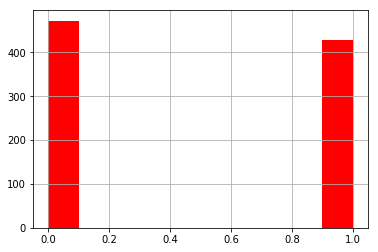

In [70]:
# Посмотрим на распределение классов в тренировочной
%matplotlib inline
ax = y_train.hist(color='red')

print('Distribution of target:')
y_train.value_counts() / y_train.shape[0]

Distribution of target:


0    0.569767
1    0.430233
Name: ClosingPrice_bin, dtype: float64

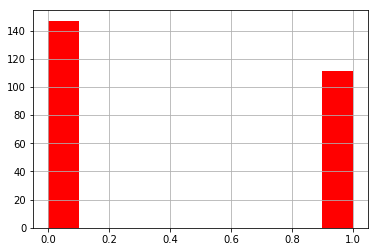

In [71]:
# И в тестовой выборке
ax = y_test.hist(color='red')

print('Distribution of target:')
y_test.value_counts() / y_test.shape[0]

In [93]:
@timeit
def vectorize(vectorizer, X_train, X_test, vectorizer_params=None):
    vectorizer = (vectorizer(**vectorizer_params) if vectorizer_params else vectorizer())
    vectorizer.fit(X_train)
    X_train = vectorizer.transform(X_train)
    X_test = vectorizer.transform(X_test)
    
    return X_train, X_test

@timeit
def get_prediction(classifier, X_train, X_test, y_train, vectorizer_params=None, classifier_params=None):
    try:
        classifier = (classifier(**classifier_params) if classifier_params else classifier())
        classifier.fit(X_train, y_train)
    except:
        classifier.fit(X_train, y_train)
    
    return classifier.predict(X_test)

@timeit
def get_score(y_true, y_predicted):
    return accuracy_score(y_true, y_predicted), f1_score(y_true, y_predicted)


In [47]:
# Попробуем с Bag-of-word
accuracy_bow, f1_score_bow = get_score(y_test, get_prediction(LogisticRegression, 
                                                              *vectorize(CountVectorizer, texts_train, texts_test), y_train))

Function vectorize time: 190.2 ms
Function get_prediction time: 34.1 ms
Function get_score time: 1.3 ms


In [48]:
# И с Tfidf
accuracy_tfidf, f1_score_tfidf = get_score(y_test, get_prediction(LogisticRegression,
                                                                 *vectorize(TfidfVectorizer, texts_train, texts_test), y_train))

Function vectorize time: 196.2 ms
Function get_prediction time: 5.8 ms
Function get_score time: 1.2 ms


In [49]:
print('With Bag-Of-Words:')
print('\tAccuracy:', accuracy_bow)
print('\tF-measure:', f1_score_bow)

print('With Tfidf:')
print('\tAccuracy:', accuracy_tfidf)
print('\tF-measure:', f1_score_tfidf)

With Bag-Of-Words:
	Accuracy: 0.488372093023
	F-measure: 0.388888888889
With Tfidf:
	Accuracy: 0.527131782946
	F-measure: 0.336956521739


Мы видим, что tfidf преобразование дает небольшой прирост к качеству классификации. Но все равно остается на уровне рандома. Попробуем подобрать гиперпараметры классификатора

In [53]:
X_train_vect, X_test_vect = vectorize(TfidfVectorizer, texts_train, texts_test)

params = {'C': [x for x in np.linspace(0.01, 10, num=1000)],
          'penalty': ['l1', 'l2']}

classifier = LogisticRegression()

Function vectorize time: 190.3 ms


In [55]:
%%time
cv = GridSearchCV(estimator=classifier, param_grid=params, scoring=make_scorer(accuracy_score, greater_is_better=False), 
                  n_jobs=-1)

CPU times: user 33 µs, sys: 2 µs, total: 35 µs
Wall time: 37 µs


In [56]:
%%time
cv.fit(X_train_vect, y_train)
y_predicted_best = cv.predict(X_test_vect)

CPU times: user 4.74 s, sys: 92 ms, total: 4.83 s
Wall time: 40.4 s


In [57]:
print('Best score:')
print('\tAccuracy:', get_score(y_test, y_predicted_best)[0])
print('\tF1-measure:', get_score(y_test, y_predicted_best)[1])
print('Best estimator:')
print(cv.best_estimator_)

Best score:
Function get_score time: 1.6 ms
	Accuracy: 0.573643410853
Function get_score time: 1.6 ms
	F1-measure: 0.051724137931
Best estimator:
LogisticRegression(C=0.75, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


Подбор гиперпараметров дал прирост к качеству. Данные значения можно взять за бейслайн. Или "гразный хак":

In [58]:
y_predicted_hack = [0 for _ in range(y_test.shape[0])]
print('Score:')
print('\tAccuracy:', accuracy_score(y_test, y_predicted_hack))
print('\tF1-measure:', f1_score(y_test, y_predicted_hack))

Score:
	Accuracy: 0.56976744186
	F1-measure: 0.0


/home/kirill/Machine_Learning/ML_venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Можно увидеть, что подбор параметров и векторизация дали очень малый прирост по сравнению с простым заполнением ответов нулями

## Часть 3. Творческая [4 балла]
Придумайте и попытайтесь сделать еще что-нибудь, чтобы улучшить качество классификации. 
Направления развития:
* Морфологический признаки: 
    * использовать в качестве признаков только существительные или только именованные сущности;
* Модели скрытых тем:
    * использовать в качестве признаков скрытые темы;
    * использовать в качестве признаков динамические скрытые темы 
    пример тут: (https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/dtm_example.ipynb)
* Синтаксические признаки:
    * использовать SOV-тройки в качестве признаков
    * кластеризовать SOV-тройки по усредненным эмбеддингам  (обученные word2vec модели можно скачать отсюда: (http://rusvectores.org/ru/models/ или https://github.com/facebookresearch/fastText/blob/master/pretrained-vectors.md) и использовать только центроиды кластеров в качестве признаков
* что-нибудь еще     

In [100]:
def get_nouns(word_list):
    morph = MorphAnalyzer()
    
    return [word for word in word_list if morph.parse(word)[0].tag.POS == 'NOUN']

@timeit
def get_nouns_in_df(info):
    info['text'] = all_info['text'].apply(lambda news_list: [get_nouns(word_list) for word_list in news_list])
    
    return info

In [101]:
info = lemmatize_in_df(tokenize_in_df(merge_dataframes(*clean_data(*load_data()))))

Function load_data time: 29.9 ms
Function clean_data time: 512.8 ms
Function merge_dataframes time: 4.3 ms
Function tokenize_in_df time: 1930.2 ms
Function lemmatize_in_df time: 18100.7 ms


In [102]:
info = get_nouns_in_df(info)

Function get_nouns_in_df time: 134402.1 ms


In [103]:
info.head()

,date,text,Open,ClosingPrice,DailyHigh,DailyLow,VolumePcs
0,2010-01-02,"[[газпром, выпуск, облигация, половина, объём,...",184.74,189.85,190.40,183.50,76298175
1,2010-01-19,"[[газпром, газа, баку, вторник, глава, газпром...",190.10,189.76,190.47,187.36,48626727
2,2010-01-28,"[[консорциум, глава, оао, газпром, нефть, четв...",183.75,182.30,185.98,181.67,62561241
3,2010-02-07,"[[газпромбанк, кипр, компания, компания, деяте...",144.80,148.25,148.27,144.05,41766629
4,2010-02-09,"[[газпром, прогноз, экспорт, европа, уровень, ...",161.79,162.80,163.57,161.53,42721026


In [104]:
X_train, X_test, y_train, y_test = get_train_test(prepeare_data(info))

Function prepeare_data time: 45.3 ms
Function get_train_test time: 3.1 ms


In [105]:
# Попробуем обучиться только на существительных

X_train_vect, X_test_vect = vectorize(TfidfVectorizer, X_train, X_test, {'ngram_range':(1, 3)})
y_predicted = get_prediction(LogisticRegression(), X_train_vect, X_test_vect, y_train)

Function vectorize time: 488.9 ms
Function get_prediction time: 28.0 ms


In [106]:
print('Accuracy:', get_score(y_test, y_predicted)[0])
print('F1-score:', get_score(y_test, y_predicted)[1])

Function get_score time: 2.0 ms
Accuracy: 0.546511627907
Function get_score time: 1.8 ms
F1-score: 0.299401197605


Можно увидеть, что при обучении только на существительных качество пресказания упало<br>
Таким образом наилучший пайплайн: Tfidf-векторизация + логистическая регрессия

## Сдача домашнего задания

Дедлайн сдачи домашнего задания:  23:59 22.03.2018. Каждый день просрочки дедлайна штрафуется -1 баллом.

Результаты домашнего задания должны быть оформлены в виде отчета в jupyter notebook.
Нормальный отчёт должен включать в себя:
* Краткую постановку задачи и формулировку задания
* Описание минимума необходимой теории и/или описание используемых инструментов 
* Подробный пошаговый рассказ о проделанной работе
* **Аккуратно** оформленные результаты
* Подробные и внятные ответы на все заданные вопросы 
* Внятные выводы – не стоит относится к домашнему заданию как к последовательности сугубо технических шагов, а стоит относится скорее как к небольшому практическому исследованию, у которого есть своя цель и свое назначение.

Задание выполняется в группе до трех человек. Не забудьте перечислить фамилии всех, кто работал над домашнем задании, в jupyter notebook.  

В случае использования какого-либо строннего источника информации обязательно дайте на него ссылку (поскольку другие тоже могут на него наткнуться). Плагиат наказывается нулём баллов за задание и предвзятым отношением в будущем.


При возникновении проблем с выполнением задания обращайтесь с вопросами к преподавателю по семинарским занятиям в вашей группе или у учебным ассистентам.

Учебный ассистент по ДЗ 2: Таисия Глушкова (email: glushkovato@gmail.com, telegram: @glushkovato).


Небрежное оформление отчета существенно отразится на итоговой оценке. Весь код из отчёта должен быть воспроизводимым, если для этого нужны какие-то дополнительные действия, установленные модули и т.п. — всё это должно быть прописано в отчете в явном виде.

Сдача отчетов осуществляется через систему AnyTask.

